Language Translation
=============================

<b>Author: Srikanth Babu Mandru


### Connect Colab to the Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
import os
import sys

In [ ]:

path = '/content/gdrive/My Drive/NLP/project/'
os.chdir(path)
print(os.getcwd())

### Import libraries

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


Loading data files
==================


In [ ]:
SOS_token = 0
EOS_token = 1
OOV_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS" : 0, "EOS" : 1, "OOV" : 2 }
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS" , 2: "OOV"}
        self.n_words = 3  # Count SOS, EOS and OOV tokens
        self.max_seq_length = -1

    def addSentence(self, sentence):
        ### Compute the maximum sequence length (useful for decoder)
        sentence_splitted = sentence.split(' ')
        if len(sentence_splitted) > self.max_seq_length:
            self.max_seq_length = len(sentence_splitted)
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s, lang_name):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r" _?\s", r"", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"\% ?[a-z]", "", s)

    w = s

    if lang_name == 'en':
        w = re.sub(r"[^a-zA-Z0-9?'.!,¿\-\/]+", " ", w)
        w = re.sub(r" - ", "-", w)
    elif lang_name == 'hi':  ## In future, this can be modified to use the "Indic NLP toolkit"
        w = re.sub(r"([\-])", r"\1", w)
        # w = re.sub(r"([\/])", r" \1 ", w)
        w = re.sub(r"/", r" / ", w)
        ## since there is nothing like "¿" in Hindi
        w = re.sub(r"[¿]+", "", w)
        ## since i see a extra letters from English in the open braces
        w = re.sub(r"\(.*\)", "", w)
        ## since i see a extra letters from English in the open braces
        w = re.sub(r"(\&.*lt\;.*bgt\;)", "", w)
        w = re.sub(r"(lt;.*bgt;)", "", w)
        w = re.sub(r"lt\; bgt\;", "", w)

        ### Replace the english characters
        w = re.sub(r"[a-zA-Z]+?\s", "", w) 
        
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()
    # s = re.sub(r"([.!?])", r" \1", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = []

    # Split every line into pairs and normalize
    for l in lines:
        sents = l.split('\t')
        sent_pair = []
        for i, sent in enumerate(sents):
            if i == 0:
                sent_pair.append(normalizeString(sent, lang_name = 'en'))
            elif i == 1:
                sent_pair.append(normalizeString(sent, lang_name = 'hi'))
        pairs.append(sent_pair)
        
    # pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH_CUT_OFF = 50

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH_CUT_OFF and len(p[1].split(' ')) <= MAX_LENGTH_CUT_OFF 


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
### Load the training data 
input_lang, output_lang, pairs = prepareData('en', 'hi', False)
print(random.choice(pairs))

Reading lines...
Read 1609682 sentence pairs
Trimmed to 1548269 sentence pairs
Counting words...
Counted words:
en 368797
hi 446780
['http://pranabmukherjee.nic.in/pr120216_01.html', 'http://pranabmukherjee.nic.in/prh120216_01.html']


In [ ]:
print('Training set size is : ', len(pairs) )

Training set size is :  1548269


In [ ]:
print("maximum input sequence length : " , input_lang.max_seq_length)
print("maximum output sequence length : " , output_lang.max_seq_length)

maximum input sequence length :  50
maximum output sequence length :  50


### Prepare the validation and test data

In [ ]:
def read_pairs(file_name, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    pairs = []
    input_lang_vocab = list(input_lang.word2index.keys())
    output_lang_vocab = list(output_lang.word2index.keys())

    # Split every line into pairs and normalize
    for l in lines:
        sents = l.split('\t')
        sent_pair = []
        for i, sent in enumerate(sents):
            if i == 0:
                normalized_sent = normalizeString(sent, lang_name = 'en')
                sentence1 = ''
                for token in sent.split():
                    if token in input_lang_vocab:
                        sentence1 = sentence1 + ' ' + token
                    else: 
                        sentence1 = sentence1 + ' ' + 'OOV'
                sent_pair.append(sentence1.strip())
            elif i == 1:
                normalized_sent = normalizeString(sent, lang_name = 'hi')
                sentence2 = ''
                for token in sent.split():
                    if token in output_lang_vocab:
                        sentence2 = sentence2 + ' ' + token
                    else: 
                        sentence2 = sentence2 + ' ' + 'OOV'
                        
                sent_pair.append(sentence2.strip())
                # sent_pair.append(normalizeString(sent, lang_name = 'hi'))

        pairs.append(sent_pair)

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
    print('Finished Reading!!! ')

    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    return pairs 

In [ ]:
val_set_file_name = './data/en-hi-dev.txt'



In [ ]:
### Load the validation data 
val_pairs = read_pairs(file_name = val_set_file_name, reverse = False)

print(random.choice(val_pairs))

Reading lines...
Finished Reading!!! 
Read 520 sentence pairs
Trimmed to 516 sentence pairs
['OOV and sweets were distributed among the students and teachers by the organisers of this program.', 'OOV OOV OOV समिति की ओर OOV OOV व OOV को उपहार व मिठाई वितरित की गई।']


In [ ]:
print(random.choice(val_pairs))

['OOV officers had already been promoted to the grade of OOV OOV and their current designations were upgraded to OOV OOV levels.', 'इन OOV को OOV सचिव OOV OOV OOV ही OOV OOV पद को OOV सचिव OOV OOV OOV कर दिया गया था।']


In [ ]:
print("Validation set size : " , len(val_pairs) )

Validation set size :  516


In [ ]:
test_set_file_name = './data/en-hi-test.txt'

In [ ]:
### Load the validation data 
test_pairs = read_pairs(file_name = test_set_file_name, reverse = False)
print(random.choice(test_pairs))

Reading lines...
Finished Reading!!! 
Read 2507 sentence pairs
Trimmed to 2455 sentence pairs
['OOV spend a lot of time reassuring parents -- usually, this does not signal a rapid progression into full OOV said OOV', 'OOV OOV OOV OOV OOV समय OOV को यह भरोसा OOV OOV OOV करता OOV - कि आम तौर OOV यह OOV यौवन की दिशा OOV OOV OOV को OOV OOV']


In [ ]:
print("Test set size : ", len(test_pairs) )

Test set size :  2455


The Seq2Seq Model
=================




The Encoder
-----------





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional = True) ## Changed

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1 * 2, 1, self.hidden_size, device=device) ## Changed

### Attention decoder

In [ ]:
TARGET_MAX_LENGTH = output_lang.max_seq_length + 1 ## since the we are adding the EOS and SOS tokens
print(TARGET_MAX_LENGTH)

INPUT_MAX_LENGTH = input_lang.max_seq_length + 1 ## since the we are adding the EOS and SOS tokens
print(INPUT_MAX_LENGTH)

51
51


In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=INPUT_MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 3, self.max_length) ## Changed
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size) ## Changed FROM : self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional = True ) ## Changed
        self.out = nn.Linear(self.hidden_size * 2, self.output_size) ## Changed

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0], hidden[1]), 1)), dim=1) ## Changed
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1 * 2, 1, self.hidden_size, device=device) ## Changed



Preparing Training Data
-----------------------



In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------





In [ ]:
teacher_forcing_ratio = 0.7


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_max_length=INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)


    encoder_outputs = torch.zeros(input_max_length, encoder.hidden_size * 2, device=device) ## Changed

    loss = 0

    ## Pass the input sentence through the ENCODER
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    ## Initialize the start token for decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)

    ## Pass the encoder hidden state to the decoder hidden state ("context vector" of input sentence )
    decoder_hidden = encoder_hidden

    ## since using the "Teacher forcing" i.e., passing the actual output sentence as the input to decoder
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])     ### For each decoder step (not the RNN step), compute the loss
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            ## Get the index of best output word, and pass it as input to next decoder step
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    ## backpropagate the loss 
    loss.backward()

    ### apply the gradients using the optimization update step
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [ ]:
# learning_rate=0.001
# encoder_optimizer = optim.Adam(encoder1.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(attn_decoder1.parameters(), lr=learning_rate)


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
# SAVE_PATH = './saved_model/encoder_decoder_model_50.tar'

# # #### General checkpoint saving for inference or resuming training
# torch.save({
#             'encoder_state_dict': encoder1.state_dict(),
#             'attndecoder_state_dict': attn_decoder1.state_dict(),
#             'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),            
#             'decoder_optimizer_state_dict' : decoder_optimizer.state_dict(),
#             'criterion' : criterion.state_dict(),
#             }, SAVE_PATH)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

Evaluation
==========




In [ ]:
def evaluate(encoder, decoder, pair, input_max_length = INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH ):
    with torch.no_grad():

        ## Prepare input and output tensors from the sentences
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        input_length = input_tensor.size()[0]
        target_length = target_tensor.size()[0]

        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        ## Generate the output sentence 
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(input_max_length, encoder.hidden_size * 2, device=device) ## Changed

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0] ## BUG '+'

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(input_max_length, input_max_length)

        # for di in range(input_max_length):
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)

            loss += criterion(decoder_output, target_tensor[di]).item()

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions, loss/target_length

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction 

In [ ]:
def evaluate_pairs(encoder, decoder, pairs, show_translation = False):

    n = len(pairs)
    ## Compute the average bleu score 

    bleu_scores_list = []
    loss_list = []


    for i in range(n):
        # pair = random.choice(pairs)
        pair = pairs[i]
        
        output_words, attentions, loss_value  = evaluate(encoder, decoder, pair, input_max_length = INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH )
        output_sentence = ' '.join(output_words)

        if show_translation == True:
            print('English sentence : ', pair[0])
            print('Hindi Sentence : ', pair[1])
            print('predicted output sentence : ', output_sentence)

        actual_sent_splitted = pair[1].split()
        output_sent_splitted = output_sentence.split()
        
        smoothing_function = SmoothingFunction().method4
        sent_bleu_score = 0.0

        try:
          sent_bleu_score = sentence_bleu(references = [actual_sent_splitted] ,  hypothesis = output_sent_splitted , weights = (0.25, 0.25, 0.25, 0.25), smoothing_function =  smoothing_function )
        except:
          pass

        bleu_scores_list.append(sent_bleu_score)
        loss_list.append(loss_value)

    avg_bleu_score = np.nanmean(bleu_scores_list, )
    avg_loss_value = np.nanmean(loss_list)
    # print('Bleu score is : ', avg_bleu_score )
    # print('')
    return avg_loss_value, avg_bleu_score

Training and Evaluating
=======================


In [ ]:
def trainIters(encoder, decoder, encoder_optimizer , decoder_optimizer, n_iters, print_every=10000, plot_every=10000):
    start = time.time()
    train_plot_losses = []
    val_plot_losses = []
    train_plot_bleu_scores = []
    val_plot_bleu_scores = []
    max_val_bleu_score = -1.0

    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print_bleu_total = 0

    training_pairs = []
    training_sentence_pairs = []

    for i in range(n_iters):
        sent_pair = random.choice(pairs)
        training_pairs.append(tensorsFromPair(sent_pair))
        training_sentence_pairs.append(sent_pair)

    # training_pairs = [tensorsFromPair(random.choice(pairs))
    #                   for i in range(n_iters)]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, input_max_length = INPUT_MAX_LENGTH, target_max_length = TARGET_MAX_LENGTH )

        _, sent_bleu_score = evaluate_pairs(encoder , decoder, pairs = [training_sentence_pairs[iter-1]] )

        print_loss_total += loss
        plot_loss_total += loss
        print_bleu_total += sent_bleu_score

        ### TODO: Add evaluate step in the below if statements

        ### Compute the loss and Bleu score on both the training and deceklopnent set
        if iter % print_every == 0:
            ### -------------- Training data -------------#### 
            # train_examples_to_check = np.int(print_every/10)
            # _ , train_bleu_score = evaluate_pairs(encoder, decoder, training_pairs[-100:iter-2], show_translation = False)

            ## print loss 
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) Training-set loss: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

            ## print BLEU score 
            train_bleu_score = print_bleu_total/print_every
            print_bleu_total = 0
            print('Training set Bleu score : %.4f ' %(train_bleu_score) )

            ### --------------  Development set -------------####
            val_loss , val_bleu_score = evaluate_pairs(encoder, decoder, val_pairs, show_translation = False)

            ## print loss 
            print('%s (%d %d%%) validation loss : %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, val_loss))
            
            ## print BLEU score
            print('Validation set Bleu score : %.4f ' %(val_bleu_score) )

            train_plot_losses.append(print_loss_avg)
            val_plot_losses.append(val_loss)
            train_plot_bleu_scores.append(train_bleu_score)
            val_plot_bleu_scores.append(val_bleu_score)
            print('')

            if val_bleu_score >= max_val_bleu_score:
                print('Saving the Best Model!!!')
                max_val_bleu_score = val_bleu_score
                BEST_SAVE_PATH = './saved_model/encoder_decoder_model_best_50.tar'
                torch.save({
                            'encoder_state_dict': encoder.state_dict(),
                            'attndecoder_state_dict': decoder.state_dict(),
                            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),            
                            'decoder_optimizer_state_dict' : decoder_optimizer.state_dict(),
                            'criterion' : criterion.state_dict(),
                            }, BEST_SAVE_PATH)


        # if iter % plot_every == 0:
        #     plot_loss_avg = plot_loss_total / plot_every
        #     plot_losses.append(plot_loss_avg)
        #     plot_loss_total = 0
    
    history = {'train_loss' : train_plot_losses,
               'val_loss': val_plot_losses,
               'train_bleu_score' : train_plot_bleu_scores,
               'val_bleu_score' : val_plot_bleu_scores
               }

    return history
    # showPlot(plot_losses)

In [ ]:
RUN_NUM = 2

In [ ]:
### Total training examples - 1609682

In [ ]:

%matplotlib inline

training_history = trainIters( encoder = encoder_loaded, decoder = attn_decoder_loaded, 
                              encoder_optimizer = encoder_optimizer_loaded, decoder_optimizer = decoder_optimizer_loaded,
                              n_iters = 100000, print_every=1000)

5m 59s (- 592m 51s) (1000 1%) Training-set loss: 7.3478
Training set Bleu score : 0.0692 
6m 37s (- 655m 15s) (1000 1%) validation loss : 7.9940
Validation set Bleu score : 0.0198 

Saving the Best Model!!!
13m 7s (- 643m 18s) (2000 2%) Training-set loss: 7.2064
Training set Bleu score : 0.0609 
13m 50s (- 678m 10s) (2000 2%) validation loss : 8.9033
Validation set Bleu score : 0.0345 

Saving the Best Model!!!
20m 24s (- 660m 1s) (3000 3%) Training-set loss: 7.3058
Training set Bleu score : 0.0657 
20m 54s (- 676m 15s) (3000 3%) validation loss : 6.4973
Validation set Bleu score : 0.0205 

26m 42s (- 640m 58s) (4000 4%) Training-set loss: 7.1729
Training set Bleu score : 0.0707 
27m 32s (- 660m 51s) (4000 4%) validation loss : 10.6303
Validation set Bleu score : 0.0293 

33m 24s (- 634m 50s) (5000 5%) Training-set loss: 7.1657
Training set Bleu score : 0.0788 
34m 13s (- 650m 8s) (5000 5%) validation loss : 10.3849
Validation set Bleu score : 0.0407 

Saving the Best Model!!!
41m 0s (

#### Trails to make the code work with more data by clearing the cache

In [ ]:
# import torch
# torch.cuda.empty_cache()
# torch.cuda.memory.empty_cache()

#### Save the model

In [ ]:
SAVE_PATH = './saved_model/encoder_decoder_model_50.tar'

#### General checkpoint saving for inference or resuming training
torch.save({
            'encoder_state_dict': encoder_loaded.state_dict(),
            'attndecoder_state_dict': attn_decoder_loaded.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer_loaded.state_dict(),            
            'decoder_optimizer_state_dict' : decoder_optimizer_loaded.state_dict(),
            'criterion' : criterion.state_dict(),
            }, SAVE_PATH)

### Plot the Loss and Metrics 

In [ ]:
import json
from collections import defaultdict

In [ ]:


json.dump(training_history , open(f'./seq2seq_results_50/history_dict_run{RUN_NUM}.json', 'w'))

In [ ]:
# Read data from file:
# history_training = json.load( open( f'./seq2seq_results/history_dict_run{RUN_NUM}.json', 'r' ) )

In [ ]:
# plot_training_history  = {}

In [ ]:
plot_training_history = defaultdict(list)
# train_loss_list = []
# val_loss_list = []
# train_bleu_list= []
# val_bleu_list = []


for i in range(1, RUN_NUM +1 ):
    history_temp = json.load( open( f'./seq2seq_results_50/history_dict_run{i}.json', 'r' ) )
    # train_loss_list.extend(history_temp['train_loss'])
    # val_loss_list.extend(history_temp['val_loss'])
    # train_bleu_list.extend(history_temp['train_bleu_score'])
    # val_bleu_list.extend(history_temp['val_bleu_score'])
    plot_training_history['train_loss'].extend(history_temp['train_loss'])
    plot_training_history['val_loss'].extend(history_temp['val_loss'])
    plot_training_history['train_bleu_score'].extend(history_temp['train_bleu_score'])
    plot_training_history['val_bleu_score'].extend(history_temp['val_bleu_score'])
    
print(plot_training_history)

training_history = plot_training_history

In [ ]:
%matplotlib inline

<Figure size 432x288 with 0 Axes>

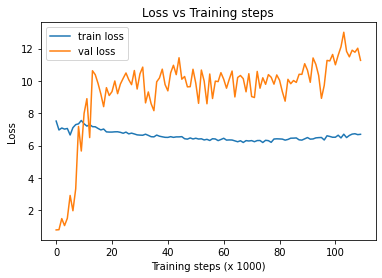

In [ ]:
## PLot the train and validation loss 
plt.figure()
fig, ax = plt.subplots()
plt.plot(training_history['train_loss'], label = 'train loss')
plt.plot(training_history['val_loss'], label = 'val loss')
plt.title('Loss vs Training steps')
plt.xlabel('Training steps (x 1000)')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'./seq2seq_results_50/loss_plot_run_all.png')
plt.show()

<Figure size 432x288 with 0 Axes>

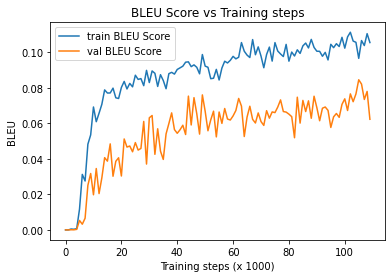

In [ ]:
## PLot the train and validation bleu score
plt.figure()
fig, ax = plt.subplots()
plt.plot(training_history['train_bleu_score'], label = 'train BLEU Score')
plt.plot(training_history['val_bleu_score'], label = 'val BLEU Score')
plt.title('BLEU Score vs Training steps')
plt.xlabel('Training steps (x 1000)')
plt.ylabel('BLEU')
plt.legend()
plt.savefig(f'./seq2seq_results_50/bleu_plot_run_all.png')
plt.show()

#### Save and reload the model to resume training

In [ ]:
SAVE_PATH = './saved_model/encoder_decoder_model_best_50.tar'


In [ ]:
#### General checkpoint saving for inference or resuming training
torch.save({
            'encoder_state_dict': encoder_loaded.state_dict(),
            'attndecoder_state_dict': attn_decoder_loaded.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer_loaded.state_dict(),            
            'decoder_optimizer_state_dict' : decoder_optimizer_loaded.state_dict(),
            'criterion' : criterion.state_dict(),
            }, SAVE_PATH)

In [ ]:
TRAIN_LOADED_MODEL = False

In [ ]:
encoder_loaded = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder_loaded = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

## Important to do the following step to freeze the layers and use the model for evaluation
# encoder_loaded.eval()
# attn_decoder_loaded.eval()

##  Load the dictionary from saved file
checkpoint = torch.load(SAVE_PATH)

# load the state from dictionary 
encoder_loaded.load_state_dict(checkpoint['encoder_state_dict'])
attn_decoder_loaded.load_state_dict(checkpoint['attndecoder_state_dict'])

if TRAIN_LOADED_MODEL:
  encoder_loaded.train()
  attn_decoder_loaded.train()
else: 
  encoder_loaded.eval()
  attn_decoder_loaded.eval()

encoder_loaded = encoder_loaded.to(device)
attn_decoder_loaded = attn_decoder_loaded.to(device)

In [ ]:
learning_rate=0.0002
encoder_optimizer_loaded = optim.Adam(encoder_loaded.parameters(), lr=learning_rate)
decoder_optimizer_loaded = optim.Adam(attn_decoder_loaded.parameters(), lr=learning_rate)

#### On Test set

In [ ]:
### Set "show_translation" = True to show the translated sentences for each test sentence

test_loss , test_bleu_score = evaluate_pairs(encoder = encoder_loaded, decoder = attn_decoder_loaded, pairs = test_pairs, show_translation = False)

In [ ]:
print("Bleu score on test set using best checkpoint (in percent): ", round(test_bleu_score*100, 4 ) )

Bleu score on test set using best checkpoint (in percent):  7.2638


In [ ]:
print("Bleu score on test set using last checkpoint (in percent): ", round(test_bleu_score*100, 4 ) ) ### Using the last checkpoint

Bleu score on test set using last checkpoint (in percent):  5.8898


### Translate the sentence 

In [ ]:
def translate(encoder, decoder, sentence, max_length=INPUT_MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size * 2, device=device) ## Changed

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        translated_sentence = ' '.join(decoded_words)

        return translated_sentence

In [ ]:
### Set "show_translation" = True to show the translated sentences for each test sentence

# test_loss_1 , test_bleu_score_1 = evaluate_pairs(encoder = encoder_loaded, decoder = attn_decoder_loaded, pairs = test_pairs[10:20], show_translation = True)

#### Reference: 

- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html 

- Modified the data preprocess stage to suit our languages

- Added code for plotting results

- modified code to include the train, validation and test metrics

- Added the translate function to translate sentences

- Modified the RNN as Bi-directional RNNs
